# Backtesting
- Compare investment strategies, such as cap-weighted vs. equal-weighted, as well as slight modifications such as filtering out assets based on set criteria

### Run a backtest using data from 1997 to 2015 comparing the performance of a cap-weighted portfolio vs an equal-weighted portfolio considering 49 industries based on their returns from the period of 1995 to 1996
- Note that the weights used for the cap-weighted are determined solely by the last day in the estimation window
- Note that the weights used for the equal-weighted portfolio are independent of the estimation window

In [1]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk
import matplotlib.pyplot as plt
%matplotlib inline

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.105963,0.160314,-0.697595,5.669240,0.072705,0.107237,0.460992,-0.528292
CW,0.095456,0.157630,-0.730908,4.341557,0.073773,0.105279,0.403966,-0.513446


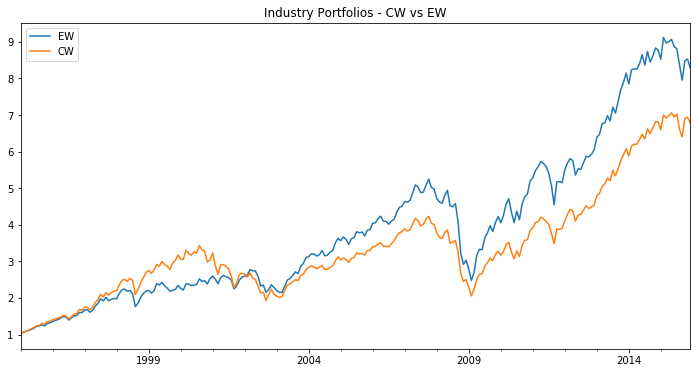

In [2]:
ind_rets = erk.get_ind_returns( weighting='vw', n_inds=49)['1994':'2015']
ind_mcap = erk.get_ind_market_caps(n_inds=49, weights=True)['1994':'2015']

cwr = erk.backtest_ws(
    ind_rets, 
    estimation_window=12, 
    weighting=erk.weight_cw, 
    cap_weights=ind_mcap
)
ewr = erk.backtest_ws(
    ind_rets,
    estimation_window=12,
    weighting=erk.weight_ew
)
btr = pd.DataFrame({'EW':ewr, 'CW':cwr})
(1+btr).cumprod()['1995':].plot(
    figsize=(12,6), 
    title='Industry Portfolios - CW vs EW'
)
erk.summary_stats(btr.dropna())

### Re-run the same backtest, but make the following changes:
- use a "tethered" EW portfolio that removes small-cap industries by using a threshold that their market-cap must be at least 1% of the total market cap
- the EW portfolio will also restrict the weight allocated to an asset to be 2X their cap-weighted value


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW-T,0.104577,0.150748,-0.754091,4.423871,0.069754,0.098388,0.481321,-0.502560
CW,0.095456,0.157630,-0.730908,4.341557,0.073773,0.105279,0.403966,-0.513446


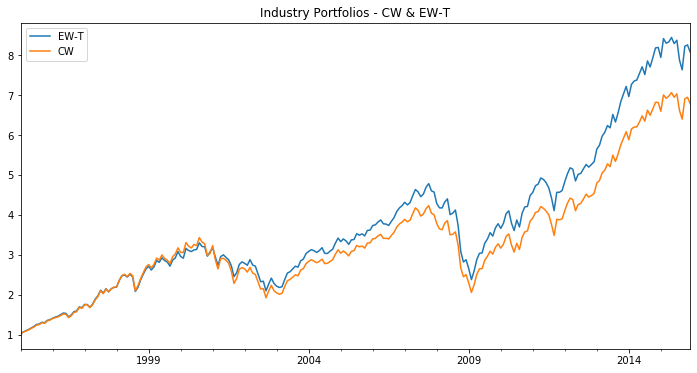

In [3]:
ewr_tethered = erk.backtest_ws(
    ind_rets,
    estimation_window=12,
    weighting=erk.weight_ew,
    max_cw_mult=2,
    microcap_threshold=0.01,
    cap_weights=ind_mcap
)

btr = pd.DataFrame({'EW-T':ewr_tethered, 'CW':cwr})
(1+btr).cumprod()['1995':].plot(
    figsize=(12,6), 
    title='Industry Portfolios - CW & EW-T'
)
erk.summary_stats(btr.dropna())

### Calculate the tracking error between the EW portfolio and CW portfolio
- Tracking error is a measure of risk that shows how closely a portfolio's returns follows an benchmark index's returns
- $TE = \sqrt{\text{Var}(r_p - r_b)}$

In [4]:
erk.tracking_error(ewr, cwr)

0.2372471154235622

### Calculate the tracking error between the tethered EW and CW portfolio

In [5]:
erk.tracking_error(ewr_tethered, cwr)

0.09158241771833346

### Run a backtest on the GMV portfolio over the same period. Calculate the weights based on the same 12-month window (returns in 1994)

In [6]:
gmvr = erk.backtest_ws(
    ind_rets, 
    estimation_window=12, 
    weighting=erk.weight_gmv, 
)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
GMV,0.076475,0.139872,-0.983899,6.105952,0.067304,0.092720,0.323211,-0.432548
EW-T,0.104577,0.150748,-0.754091,4.423871,0.069754,0.098388,0.481321,-0.502560
CW,0.095456,0.157630,-0.730908,4.341557,0.073773,0.105279,0.403966,-0.513446


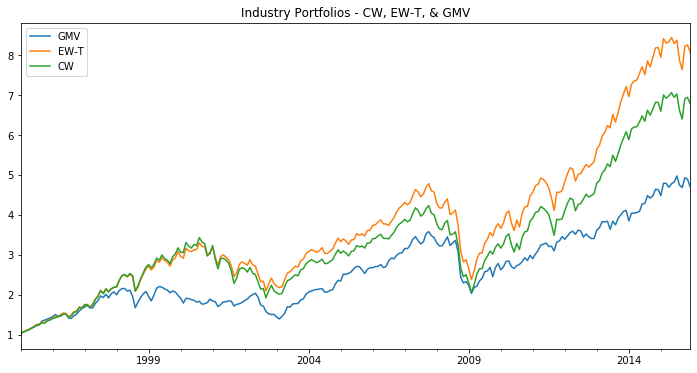

In [8]:
btr = pd.DataFrame({'GMV':gmvr, 'EW-T':ewr_tethered, 'CW':cwr})
(1+btr).cumprod()['1995':].plot(
    figsize=(12,6), 
    title='Industry Portfolios - CW, EW-T, & GMV'
)
erk.summary_stats(btr.dropna())

### Run the same backtest, but when calculating the GMV weights, estimate the covariance matrix using skrinkage between the constant correlation and sample covariance estimates with a 0.25 delta

```python
def shrinkage_cov(r, delta=0.5, **kwargs):
    """
    Covariance estimator that shrinks between the Sample Covariance and the Constant Correlation Estimators
    """
    prior = cc_cov(r, **kwargs)
    sample = sample_cov(r, **kwargs)
    return delta*prior + (1-delta)*sample

def cc_cov(r, **kwargs):
    """
    Estimates a covariance matrix by using the Elton/Gruber Constant Correlation model
    """
    rhos = r.corr()
    n = rhos.shape[0]
    # this is a symmetric matrix with diagonals all 1 - so the mean correlation is ...
    rho_bar = (rhos.values.sum()-n)/(n*(n-1))
    ccor = np.full_like(rhos, rho_bar)
    np.fill_diagonal(ccor, 1.)
    sd = r.std()
    return pd.DataFrame(ccor * np.outer(sd, sd), index=r.columns, columns=r.columns)
```

In [9]:
gmvr_shrinkage = erk.backtest_ws(
    ind_rets, 
    estimation_window=12, 
    weighting=erk.weight_gmv, 
    cov_estimator=erk.shrinkage_cov,
    delta=0.25
)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
GMV_Shrinkage,0.103281,0.133801,-1.061922,6.354629,0.062632,0.086261,0.532904,-0.413038
GMV,0.076475,0.139872,-0.983899,6.105952,0.067304,0.092720,0.323211,-0.432548
EW-T,0.104577,0.150748,-0.754091,4.423871,0.069754,0.098388,0.481321,-0.502560
CW,0.095456,0.157630,-0.730908,4.341557,0.073773,0.105279,0.403966,-0.513446


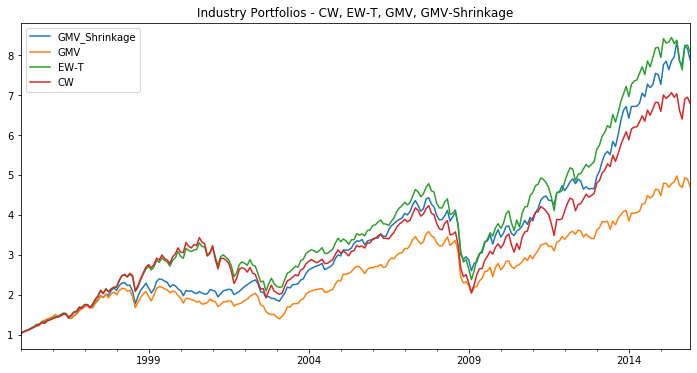

In [10]:
btr = pd.DataFrame({
    'GMV_Shrinkage':gmvr_shrinkage,
    'GMV':gmvr,
    'EW-T':ewr_tethered,
    'CW':cwr})
(1+btr).cumprod()['1995':].plot(
    figsize=(12,6), 
    title='Industry Portfolios - CW, EW-T, GMV, GMV-Shrinkage'
)
erk.summary_stats(btr.dropna())